In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
#import pandas as pd
from tqdm import tqdm
import os
import torch.nn.functional as F
from torch.utils.data import Dataset 

In [2]:
import cv2
import scipy

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [4]:
data_path = 'image'
camera_list = []
for data in sorted(os.listdir(data_path)):
    camera_list.append(data)

In [5]:
images = []
labels = []
for i in range(len(camera_list)):
    for data in sorted(os.listdir('./image/'+str(camera_list[i]))):
        path = './image/'+str(camera_list[i]) +'/' + data
        basename = os.path.basename(path) # example.jpg
        #filename = os.path.splitext(basename)[0] # example
        file = os.path.splitext(basename)[1] #.jpg
        if file == '.jpg':
            images.append('./image/'+str(camera_list[i]) + '/' + basename)
        elif file == '.txt':
            labels.append('./image/'+str(camera_list[i]) + '/' + basename)

In [50]:
#generate density map and save
sigma = 16
for j in tqdm(range(len(images))):
    image = cv2.imread(images[j])
    '''if image.shape[0] < crop_size or image.shape[1] < crop_size:
        continue'''
    points = []    
    with open (labels[j], 'r') as f:
        while True:
            point = f.readline()
            if not point:
                break
            point = point.split('\t')
            points.append([float(point[0]), float(point[1])])
    label_position = np.array(points)
    #label_position = np.load(labels[j])
    label_image = np.zeros((image.shape[0],image.shape[1]))
    for i in range(len(label_position)):
        label_image[int(label_position[i,1]) - 1, int(label_position[i,0]) - 1] = 1
    density_map = scipy.ndimage.gaussian_filter(label_image, sigma = sigma, truncate= sigma)
    '''if not os.path.isdir('density_map_npy_16'):
            os.mkdir('density_map_npy_16')'''
    basename_label = os.path.basename(labels[j]) # example.jpg
    filename_label = os.path.splitext(basename_label)[0] # example
    #np.save(('density_map_npy/'+filename_image+'.npy'),image)
    save_path = os.path.split(labels[j])[0]
    np.save((save_path+'/'+filename_label),density_map)

100%|██████████| 200/200 [00:08<00:00, 22.82it/s]


In [6]:
images = []
labels = []
density_map = []
for i in range(len(camera_list)):
    for data in sorted(os.listdir('./image/'+str(camera_list[i]))):
        path = './image/'+str(camera_list[i]) +'/' + data
        basename = os.path.basename(path) # example.jpg
        #filename = os.path.splitext(basename)[0] # example
        file = os.path.splitext(basename)[1] #.jpg
        if file == '.jpg':
            images.append('./image/'+str(camera_list[i]) + '/' + basename)
        elif file == '.txt':
            labels.append('./image/'+str(camera_list[i]) + '/' + basename)
        else:
            if basename.split('_')[0] != 'confident':
                density_map.append('./image/'+str(camera_list[i]) + '/' + basename)

In [7]:
images = np.array(images).reshape(-1,5)
labels = np.array(labels).reshape(-1,5)
density_map = np.array(density_map).reshape(-1,5)
images.shape, labels.shape, density_map.shape

((40, 5), (40, 5), (40, 5))

In [9]:
#CSRNet
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                #self.frontend.state_dict().items()[i][1].data[:] = mod.state_dict().items()[i][1].data[:]
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = F.upsample_bilinear(x, scale_factor=8)
        x = self.output_layer(x)
        #x = F.upsample_bilinear(x, scale_factor=8)
        #x = nn.Conv2d(1, 1, 1)(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [10]:
def transform(image):
      #image = torch.from_numpy(image)
      
      transform = transforms.Compose(
          [          
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
      image = transform(image)
      return image

In [11]:
adaptation_steps = 15
loss = torch.nn.MSELoss().cuda()
density_map_scale = 10

In [12]:
from learn2learn.algorithms import MAML

In [13]:
model = torch.load('save_weights/CSRNet_sigma16.pt')
model = MAML(model, lr=3e-2, allow_nograd=False).to(device)

In [14]:
#model = torch.load('save_weights/CSRNet_sigma16.pt')
mae = 0.0
prediction_list = []
for i in tqdm(range(len(images))):
    learner = model.clone()
    #data, labels = torch.from_numpy(test_sup_images[i]), torch.from_numpy(test_sup_labels[i])
    image_data = images[i]
    image = cv2.imread(image_data[0])
    image = transform(image)
    image = torch.unsqueeze(image, 0).to(device)
    image = image.float()
    labels = density_map[i]
    label = np.load(labels[0])
    #count = np.sum(label)
    label = np.expand_dims(label, axis=2)
    label = label * density_map_scale
    label = label.transpose((2, 0, 1))
    label = torch.from_numpy(label)
    label = torch.unsqueeze(label, 0)
    label = label.float()
    label = label.to(device)
    
    for step in range(adaptation_steps):
        '''transform_data = data
        for i in range(len(transform_data)):
            image = transform(transform_data[i])
            transform_data[i] = image
        train_error = loss(learner(transform_data), labels)'''
        #print(learner(adaptation_data).shape)
        #print(adaptation_data.shape)
        output = learner(image)
        train_error = loss(output, label)
        #print(train_error)
        learner.adapt(train_error)

    # Compute validation loss
    with torch.no_grad():
        for j in range(1, len(image_data)):
            test_data = cv2.imread(image_data[j])
            test_data = transform(test_data)
            test_data = torch.unsqueeze(test_data, 0)
            test_data = test_data.to(device)
            predictions = learner(test_data)
            prediction_list.append(predictions.cpu()) 
            predict_count = torch.sum(predictions).cpu().detach().numpy().item() / density_map_scale
            label = np.load(labels[j])
            count = np.sum(label)
            error = np.abs(count - predict_count)
            mae += error
        

  0%|          | 0/40 [00:00<?, ?it/s]c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torch\nn\functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


In [15]:
mae / (40*4)

4.491545359119771

In [16]:
test_images = []
test_density = []
for i in range(len(images)):
    for j in range(1, images.shape[1]):
        test_images.append(images[i][j])
        test_density.append(density_map[i][j])

In [17]:
import matplotlib.pyplot as plt

In [17]:
demo = prediction_list[2][0].numpy().transpose((1, 2, 0))
demo.shape      

(240, 352, 1)

In [18]:
i = 62
predict = prediction_list[i][0].numpy().transpose((1, 2, 0))
predict_sum = np.sum(predict) / density_map_scale
image = cv2.imread(test_images[i])
density = np.load(test_density[i])
predict_sum, np.sum(density)

(5.821215057373047, 8.999999999999998)

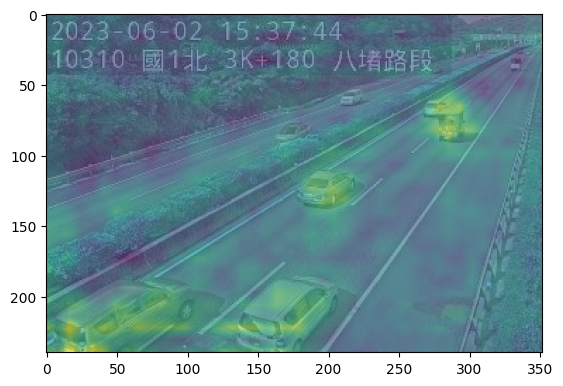

In [19]:
plt.imshow(image,alpha=0.8)
plt.imshow(predict, alpha=0.6)

In [106]:
demo = np.load('image/10261/3.npy')
image = cv2.imread('image/10261/3.jpg')


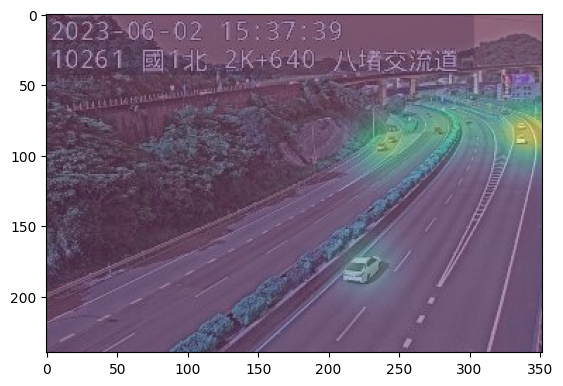

In [107]:
plt.imshow(image,alpha=0.8)
plt.imshow(demo, alpha=0.4)

In [35]:
demo = prediction_list[5][0].numpy().transpose((1, 2, 0))

In [36]:
np.sum(demo)/density_map_scale

230.90578125

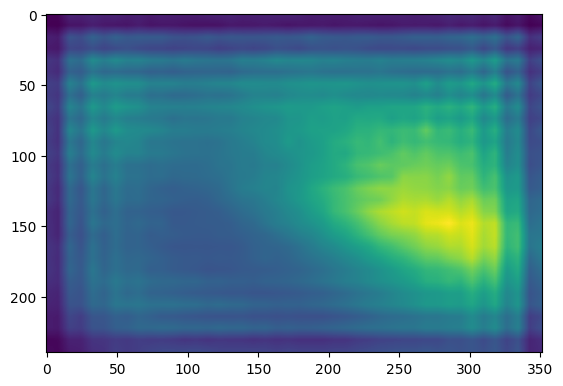

In [39]:
plt.imshow(demo/ density_map_scale)

Without few shot learning

In [35]:
model = torch.load('save_weights/CSRNet_sigma16.pt')
mae = 0.0
prediction_list = []
for i in tqdm(range(len(images))):
    learner = model
    image_data = images[i]
    labels = density_map[i]
    # Compute validation loss
    with torch.no_grad():
        for j in range(1, len(image_data)):
            test_data = cv2.imread(image_data[j])
            test_data = transform(test_data)
            test_data = torch.unsqueeze(test_data, 0)
            test_data = test_data.to(device)
            predictions = learner(test_data)
            prediction_list.append(predictions.cpu()) 
            predict_count = torch.sum(predictions).cpu().detach().numpy().item() / density_map_scale
            label = np.load(labels[j])
            count = np.sum(label)
            error = np.abs(count - predict_count)
            mae += error
        

  0%|          | 0/40 [00:00<?, ?it/s]c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torch\nn\functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 40/40 [00:03<00:00, 13.03it/s]


In [36]:
mae / (4*40)

11.057829408012328

In [42]:
i = 103
predict = prediction_list[i][0].numpy().transpose((1, 2, 0))
predict_sum = np.sum(predict) / density_map_scale
#predict = pred_density_list[i][0].numpy().transpose((1, 2, 0))
image = cv2.imread(test_images[i])
density = np.load(test_density[i])

In [43]:
np.sum(density)

11.999999999999998

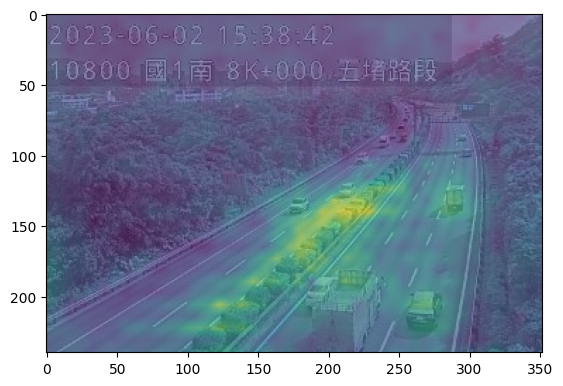

In [44]:
plt.imshow(image,alpha=0.8)
plt.imshow(predict, alpha=0.6)